In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
from quagmire import SurfaceProcessMesh
%matplotlib inline



In [2]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.005, 0.005

x1, y1, bmask1 = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 100000, 1000)

i = np.random.permutation(len(x1))

x = x1[i]
y = y1[i]
bmask = bmask1[i]
# x, y = meshtools.lloyd_mesh_improvement(x, y, bmask, 5)

In [3]:
DM = meshtools.create_DMPlex_from_points(x, y, bmask)

In [4]:
sp = SurfaceProcessMesh(DM)

 - Delaunay triangulation 0.183942s
 - cKDTree 0.031428s
 - Calculate node weights and area 1.21203s
 - Compute edge lengths 0.160735s
 - Construct nearest neighbour array 0.604424s
 - Find boundaries 0.021411s
 - Build smoothing matrix 0.041087s
 - Construct neighbour cloud array 0.409721s
 - Construct rbf weights 0.127617s


In [5]:
radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(10.0*theta)**2 ## Less so
height  += 0.5 * (1.0-0.2*radius)
height  += np.random.random(height.size) * 0.01 # random noise

sp.update_height(height)

rain   = height**2
sp.update_surface_processes(rain, np.zeros_like(rain))



 - Sort nodes by field 0.177334s
 - Build downhill matrices 0.272402s
 - Upstream area 0.191043s


In [9]:
sp._construct_rbf_weights(delta=0.03)
rbf_height = sp.rbf_smoother(sp.height)
gradx, grady = sp.derivative_grad(rbf_height)
rbf_slope = np.hypot(gradx,grady)

str_slope = sp.streamwise_smoothing(sp.slope, 3, centre_weight=0.5, )

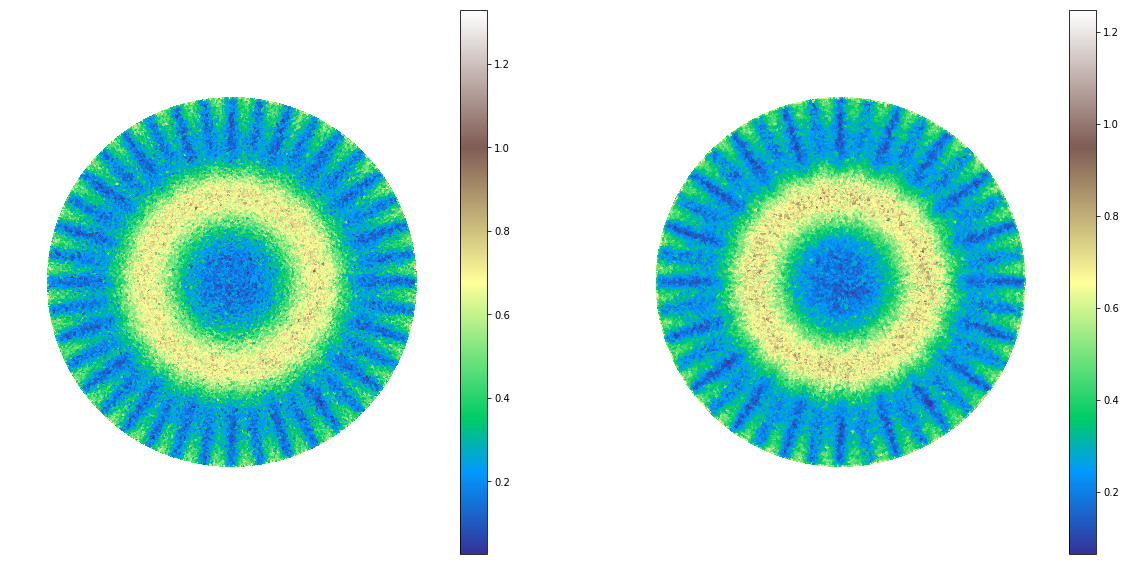

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')
    
    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, sp.slope ,     cmap='terrain')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, str_slope,     cmap='terrain')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

In [20]:
def compute_stream_power(mesh, m=1, n=1):
    """
    Stream power law (q_s)
    """
    rainflux = mesh.rainfall_pattern
    rainfall = mesh.area * rainflux
    cumulative_rain = mesh.cumulative_flow(rainfall, use3path=True)

    stream_power = cumulative_rain**m * mesh.slope**n
    return stream_power

stream_power = compute_stream_power(sp, m=1, n=1)
print stream_power.max(), stream_power.mean()
stream_power = sp.streamwise_smoothing(stream_power, 3, 0.5)
print stream_power.max(), stream_power.mean()
stream_power[~sp.bmask] = 0.0
print stream_power.max(), stream_power.mean()


cumulative_rain = sp.cumulative_flow(sp.rainfall_pattern * sp.area)

1.78064846961 0.0158680826156
0.992533942787 0.0158665865935
0.555867667971 0.0150993090935


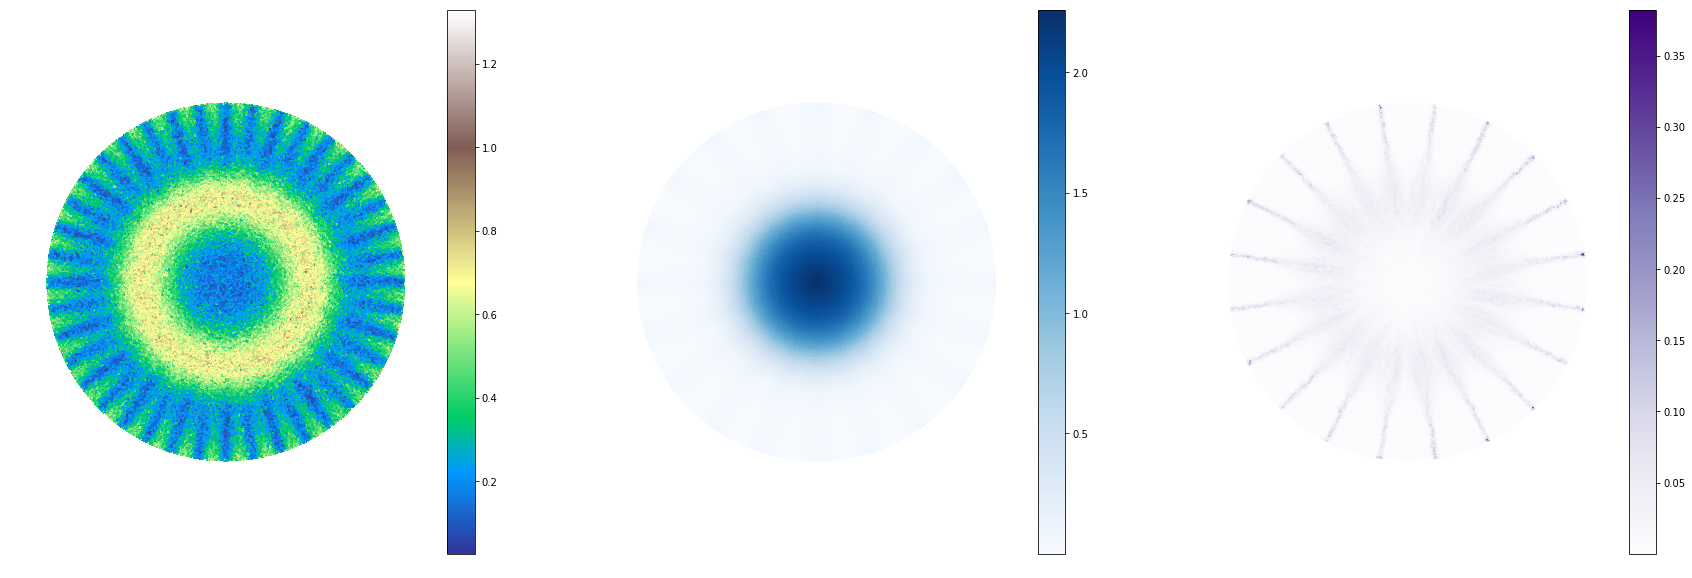

In [21]:
# Plot the height, rainfall, and stream power

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, sp.slope,     cmap='terrain')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, rain,         cmap='Blues')
im3 = ax3.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

In [ ]:
o = (np.logical_and(sp.down_neighbour2 == np.indices(sp.down_neighbour2.shape), sp.bmask == False)).flatten()
outflow_nodes = o.nonzero()[0]

print len(outflow_nodes), outflow_nodes

In [ ]:
cum_rain = cumulative_rain[outflow_nodes]
print cum_rain
print range(0,20)

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
ax1.bar( left=range(0,len(cum_rain)), height=cum_rain)



In [ ]:
r = sp.neighbour_cloud_distances[:,:5].mean(axis=1)
m = sp.neighbour_cloud_distances[:,1] 
w = rbf.gauss_dist_w[:,0]

a = w / r
a.max()/a.min()

In [ ]:
hrbf = rbf.interps(sp.height)
hrbfx, hrbfy = rbf.ddx_ddy(sp.height)
hrbfx_v2 = rbf.interps(rbf.interps(hrbfx))

In [ ]:
hx, hy = sp.derivative_grad(sp.height)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')
    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, hy**2 ,     cmap='terrain', vmax=0.5)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, hrbfy**2,   cmap='terrain', vmax=0.5)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

In [ ]:
dwx, dwy = gaussian_dx(sp, delta=None)

h5x = (sp.height[sp.neighbour_cloud[:]] * dwx[:,:]).sum(axis=1) 
h5y = (sp.height[sp.neighbour_cloud[:]] * dwy[:,:]).sum(axis=1) 

slope5 = np.hypot(h5x,h5y)

In [ ]:
# best result for slope - 1.0, 3.0  (maybe 1, 5)
# best result for d/dx  - 

delta1 = 1.0
delta2 = 2.0 
dwx, dwy = gaussian_dx(sp, 
                        delta=mesh.neighbour_cloud_distances[:,1].mean() * delta1,
                        ddelta = mesh.neighbour_cloud_distances[:,1].mean() * delta2 )

   
h5x = (sp.height[sp.neighbour_cloud[:]] * dwx[:,:]).sum(axis=1) 
h5y = (sp.height[sp.neighbour_cloud[:]] * dwy[:,:]).sum(axis=1) 
slope5 = np.hypot(h5x,h5y)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')
    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, slope5,    cmap='terrain', vmax=0.6)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, sp.slope,  cmap='terrain', vmax=0.6)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

## Timings for triangulation

``` python
x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 250000, 5000)
```

    Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
     - Delaunay triangulation 15.766856s
     - cKDTree 0.158748s
     - Calculate node weights and area 3.457745s
     - Compute edge lengths 0.463531s
     - Construct nearest neighbour array 1.639066s
     - Construct neighbour cloud array 1.485429s
     - Find boundaries 0.0570479999999s
     - Build smoothing matrix 0.102514s
     - Sort nodes by field 0.473859s
     - Build downhill matrices 1.335349s
     - Cumulative flow 1.344969s

``` python
x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 500000, 7500)
```


    Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
     - Delaunay triangulation 65.350717s
     - cKDTree 0.227902s
     - Calculate node weights and area 6.760594s
     - Compute edge lengths 1.023157s
     - Construct nearest neighbour array 3.306151s
     - Construct neighbour cloud array 2.833378s
     - Find boundaries 0.105048s
     - Build smoothing matrix 0.191309s
     - Sort nodes by field 0.880086s
     - Build downhill matrices 2.734977s
     - Cumulative flow 3.893042s


In [ ]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
delx, dely = 0.005, 0.005

x1, y1, bmask1 = meshtools.elliptical_mesh(minX, maxX, minY, maxY, delx, dely, 2000000, 5000)

i = np.random.permutation(len(x1))

x2 = x1[i]
y2 = y1[i]
bmask2 = bmask1[i]

In [ ]:
# time DM1 = meshtools.create_DMPlex_from_points(x1, y1, bmask1)

In [ ]:
# sp1 = SurfaceProcessMesh(DM1)

In [ ]:
%time DM2 = meshtools.create_DMPlex_from_points(x2, y2, bmask2)

In [ ]:
sp2 = SurfaceProcessMesh(DM2)

In [ ]:
print sp1.npoints
print sp2.npoints